In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# import image
image = cv2.imread('example_barcode.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

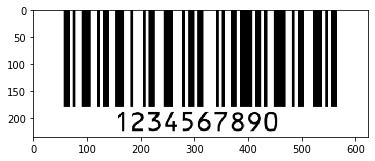

In [10]:
plt.imshow(image, 'gray')
plt.show()

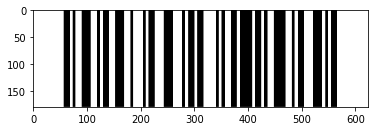

In [16]:
# we need to cut image in half
plt.imshow(image[:180,:], 'gray')

In [17]:
barcode = image[:180,:]
label = image[180:,:]

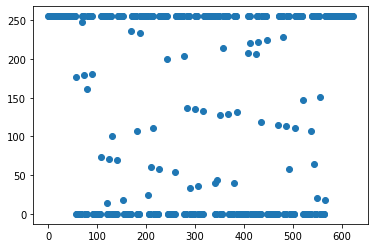

In [24]:
# convert to line
line = np.mean(barcode, axis=0)
plt.plot(line, 'o')

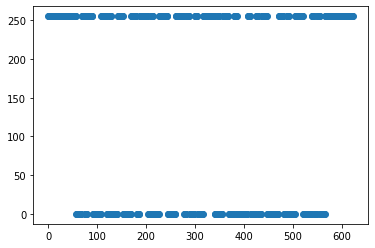

In [28]:
# get rid of intermediate pixels
a = (line.max() - line.min()) / 2
line[line < a] = line.min()
line[line > a] = line.max()
plt.plot(line, 'o')

In [39]:
[int(x) for x in line[550:570]]

[255, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 255]

In [89]:
start=[]
end=[]
color=[]

for i in range(len(line)-1):
    if i == 0:
        start.append(i)
        color.append(int(line[i]))
        
    if line[i] != line[i+1]:
        end.append(i)
        start.append(i+1)
        color.append(int(line[i+1]))
        
end.append(len(line)-1)

if len(start) == len(end):
    width = []
    for i in range(len(start)):
        width.append(end[i] - start[i] + 1)
        
width = np.array(width)
width = width[1:-1]
minvalues = width[width <= width.min() * 1.5]
minvalue = minvalues.mean()
width = [int(round(x/minvalue)) for x in width]
color = color[1:-1]
code = ''
for i in range(len(width)):
    temp = 1 - color[i]/max(color)
    temp = round(temp)
    temp = int(temp)
    temp = str(temp)
    for j in range(width[i]):
        code += temp
print(code)
print(len(code))

110100111001011001110010001011000111000101101100001010011011110110100111100101100011101011
90


In [96]:
start_symbol = code[:11]
symbols = code[11:-24]
checksum = code[-24:-13]
stop_symbol = code[-13:]

In [97]:
if start_symbol.startswith('11010000100'):
    print('A')
elif start_symbol.startswith('11010010000'):
    print('B')
elif start_symbol.startswith('11010011100'):
    print('C')
else:
    print('bad code')

C


In [98]:
stop_symbol.endswith('1100011101011')

True

In [159]:
table = open('./code128_table.txt').read().split('\n')
rows=[]
for row in table[:-1]:
    rows.append([x.strip() for x in row.split('\t')][:-1])
np.asarray(rows)
table = pd.DataFrame(rows)

In [161]:
table.columns = ['value','A', 'B', 'C', 'Code', 'Latin-1', 'Pattern']
table.tail()

,value,A,B,C,Code,Latin-1,Pattern
99,99,Code C,Code C,99,199 / 204 / 244,Ç / Ì / ô,10111011110
100,103,Start Code A,Start Code A,Start Code A,203 / 208 / 248,Ë / Ð / ø,11010000100
101,104,Start Code B,Start Code B,Start Code B,204 / 209 / 249,Ì / Ñ / ù,11010010000
102,105,Start Code C,Start Code C,Start Code C,205 / 210 / 250,Í / Ò / ú,11010011100
103,106,Stop,Stop,Stop,—,—,11000111010


In [171]:
table.loc[3,'Pattern']

'10010011000'

In [172]:
symbol = ''
for i in range(5):
    pattern = symbols[i*11 : (i+1)*11]
    symbol += table.loc[table['Pattern'] == pattern, 'C'].values[0]
print(symbol)

1234567890


yep, we got it right

In [173]:
table.loc[table['Pattern'] == checksum, 'C'].values[0]

'85'

In [179]:
# check checksum

def get_value(symbol):
    return int(table.loc[table['Pattern'] == symbol, 'value'].values[0])

accumulator = get_value(start_symbol)
for i in range(5):
    accumulator += (i+1) * get_value(symbols[i*11:(i+1)*11])
accumulator%103 == int(table.loc[table['Pattern'] == checksum, 'C'].values[0])

True